In [30]:
# load the libraries

import sys
sys.path.append('../')

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import json
import pandas as pd


from skimage import data, util
from skimage.measure import label, regionprops, regionprops_table
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.ndimage as ndi

In [46]:
# first, we shall set the image tile, WSI and output paths.

tile_path = '../data/confident_predictions/HMGA2_cluster_4_confident_tiles/'
tile_json_path = '../hovernet/results/HMGA2_cluster_4/json/'
tile_mat_path = '../hovernet/results/HMGA2_cluster_4/mat/'
tile_overlay_path = '../hovernet/results/HMGA2_cluster_4/overlay/'
cluster = 4

image_list = glob.glob(tile_path + '*.jpg')

In [47]:
# load the original image, the `.mat` file and the overlay

image_list = glob.glob(tile_path + '*.jpg')
image_list.sort()

# get a random image 
rand_nr = np.random.randint(0,len(image_list))
image_file = image_list[rand_nr]

basename = os.path.basename(image_file)
image_ext = basename.split('.')[-1]
basename = basename[:-(len(image_ext)+1)]

image = cv2.imread(image_file)
# convert from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get the corresponding `.mat` file 
result_mat = sio.loadmat(tile_mat_path + basename + '.mat')

# get the overlay
overlay = cv2.imread(tile_overlay_path + basename + '.png')

overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

inst_map = result_mat['inst_map'] 

In [48]:
# create df
# set instance as index
df = pd.DataFrame(columns=['Instance','Label']).set_index('Instance')

# fill instance column with the amount of nuclei in this tile
df = df.loc[df.index.repeat(len(np.unique(inst_map)[1:].tolist()))].assign(Instance = np.unique(inst_map)[1:].tolist()).reset_index(drop=True)
df['Label'] = cluster


In [49]:
 # load json file
# output of HoVer network containing information about individual nuclei
json_path = tile_json_path + basename + '.json'

bbox_list = []
centroid_list = []
contour_list = [] 
type_list = []

with open(json_path) as json_file:
    data = json.load(json_file)
    mag_info = data['mag']
    nuc_info = data['nuc']
    for inst in nuc_info:
        inst_info = nuc_info[inst]
        inst_centroid = inst_info['centroid']
        centroid_list.append(inst_centroid)
        inst_contour = inst_info['contour']
        contour_list.append(inst_contour)
        inst_bbox = inst_info['bbox']
        bbox_list.append(inst_bbox)
        inst_type = inst_info['type']
        type_list.append(inst_type)

# information about centroid coordinates as a list with two values
df['Centroid'] = centroid_list

# information about countour coordinates stored as a list
df['Contour'] = contour_list

# information about bounding box, stored in two lists
df['Bounding box'] = bbox_list


In [50]:
 # function to paint the contours
def paint_nucleus(img, cont):
    # contours will appear black with thickness of 6
    # this is what mimics best the output from HoVer network
    return cv2.drawContours(img, [np.array(cont)], -1, (0,0,0), 4)

# function to fill the contours
def fill_contour(img, cont):
    # each instance will be filled with white
    return cv2.fillPoly(img, pts = [np.array(cont)], color=(255,255,255))

# create new black empty image
nuc_overlay = np.zeros([598,598,3], dtype = np.uint8)

# fill image with nuclei
for i in contour_list:
    paint_nucleus(nuc_overlay,i)
    fill_contour(nuc_overlay,i)

# convert to greyscale image for regionprops
nuc_overlay = cv2.cvtColor(nuc_overlay, cv2.COLOR_BGR2GRAY)

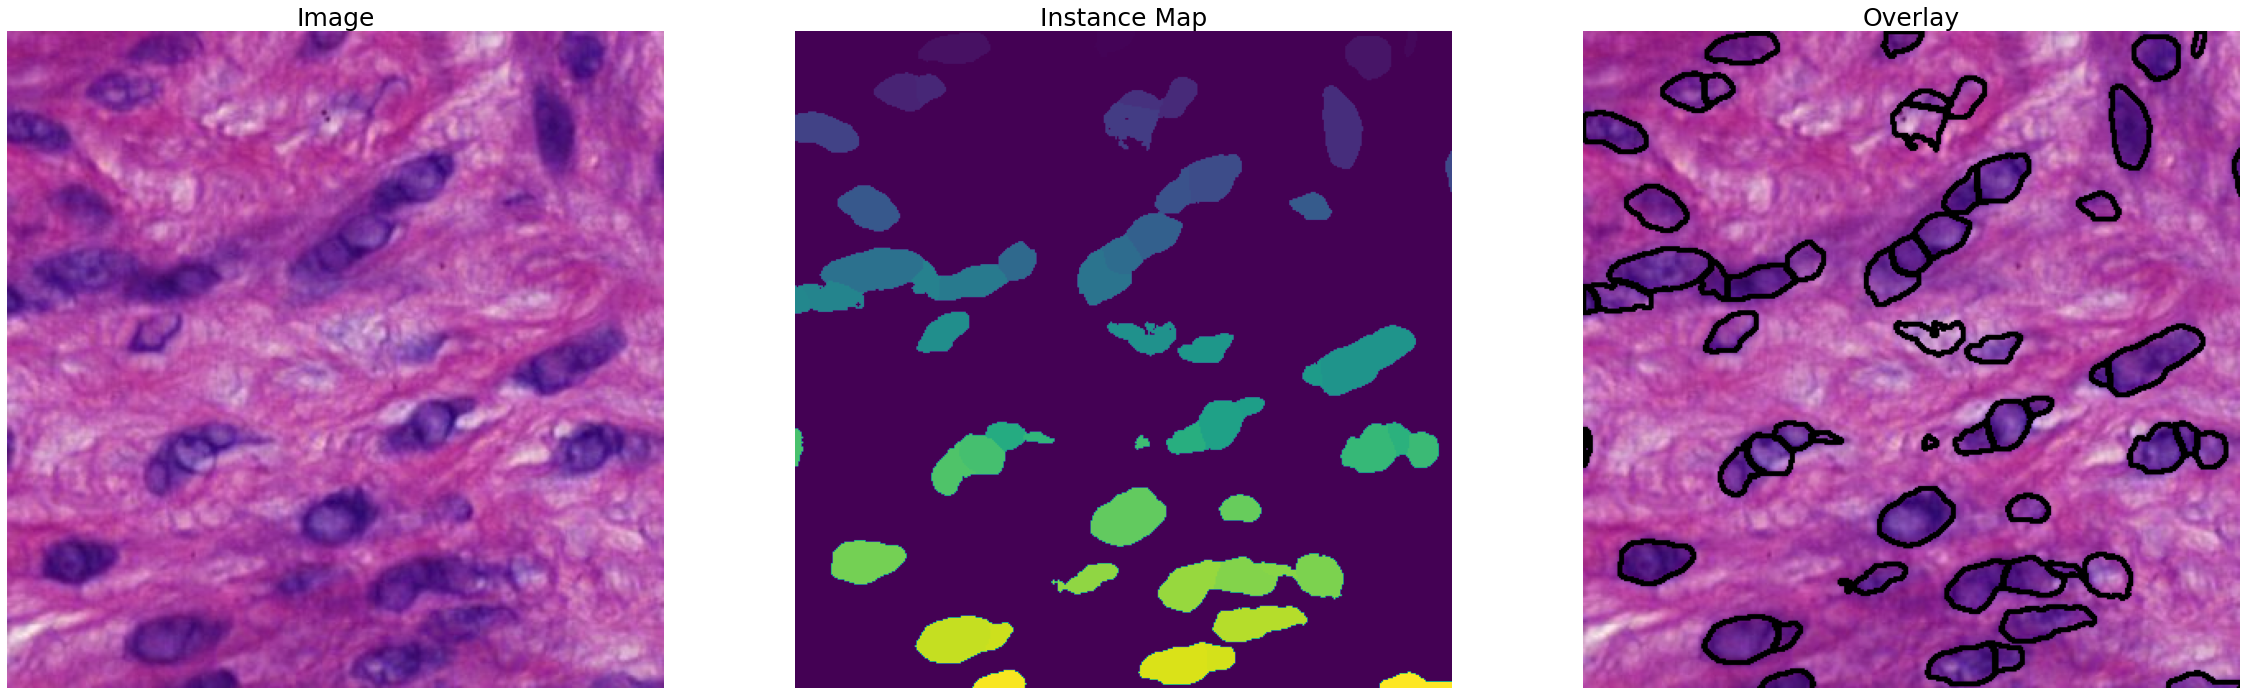

In [51]:
# plot the original image, along with the instance map and the overlay

plt.figure(figsize=(40,20))

plt.subplot(1,3,1)
plt.imshow(image[:400,:400,:])
plt.axis('off')
plt.title('Image', fontsize=25)

plt.subplot(1,3,2)
plt.imshow(inst_map[:400,:400])
plt.axis('off')
plt.title('Instance Map', fontsize=25)

plt.subplot(1,3,3)
plt.imshow(overlay[:400,:400,:])
plt.axis('off')
plt
plt.title('Overlay', fontsize=25)

plt.show()

In [53]:
# use regionprops to extract additional features from the binary image
props = regionprops_table(label(nuc_overlay), image, properties=['area','perimeter', 'equivalent_diameter','mean_intensity', 'solidity','max_intensity', 'min_intensity', 'eccentricity'])

# convert to new df
props_df = pd.DataFrame(props)

# check length of the new df to ensure all nuclei are contained
# if not, change thickness value in cv2.drawContours()
print(len(df.index) == len(props_df.index))
print(len(df.index))
print(len(props_df.index))

True
151
151


In [54]:
 # join both dataframes into one and display
df = df.join(props_df)


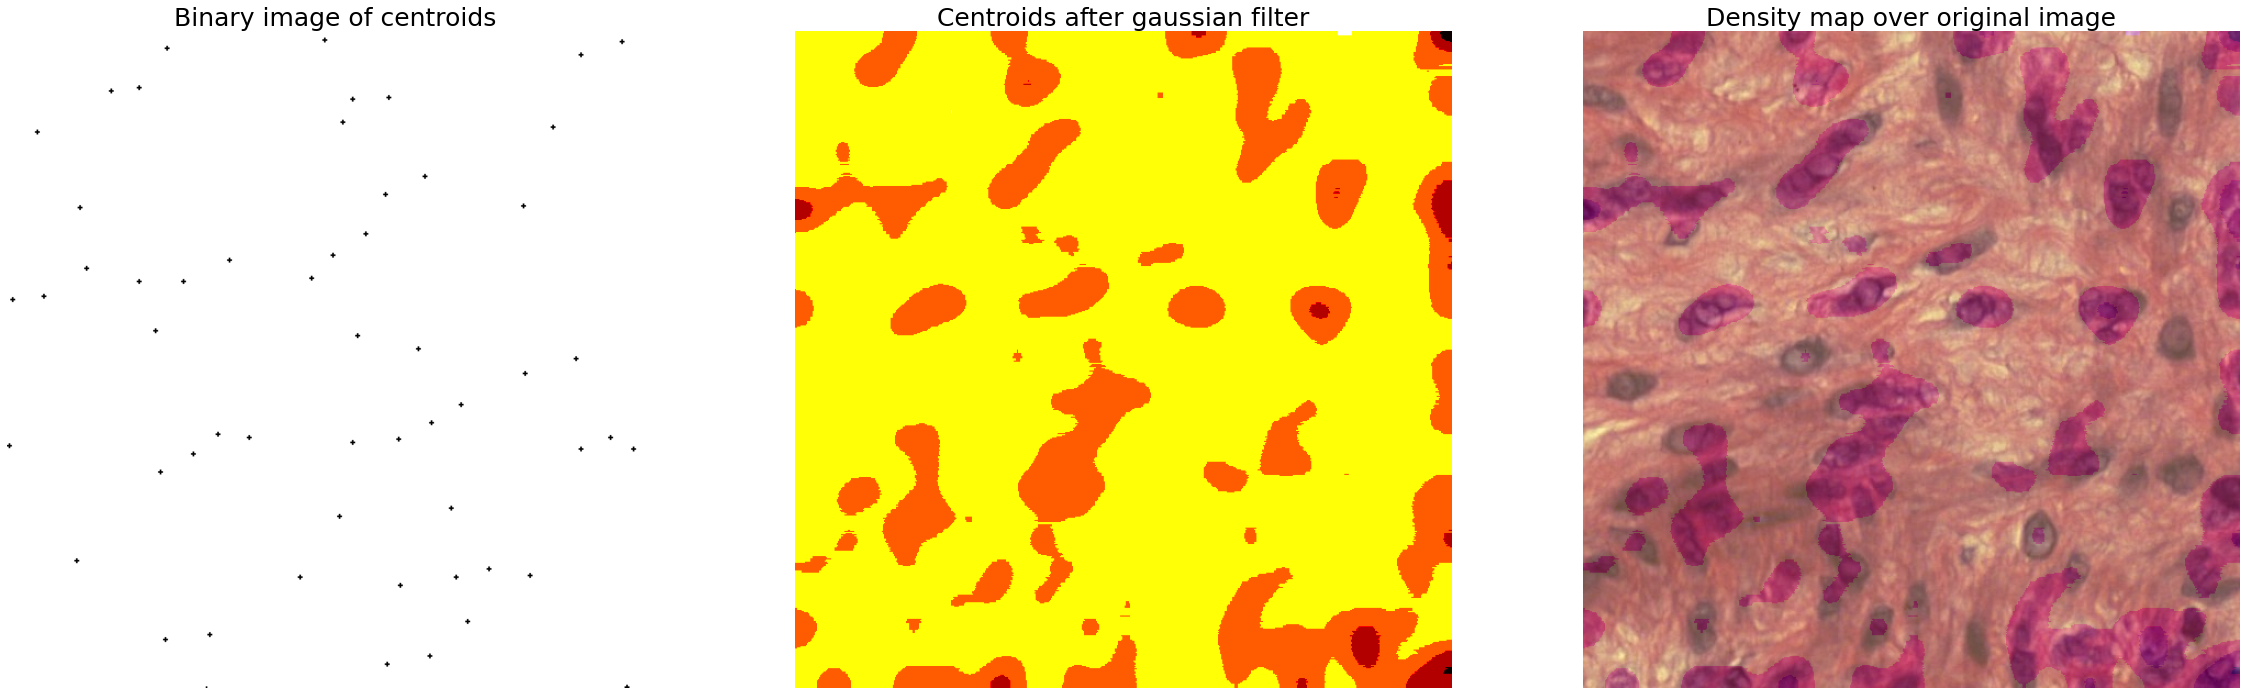

In [55]:
# round floats, except for eccentricity and solidity, which have values between 0 and 1
for col in df.columns:
    if df[col].dtypes == 'float64' and col !='eccentricity' and col!='solidity':
        df[col] = df[col].round(0).astype('int')  
        
def draw_circle(img, cent):
    # each instance will be filled with a black dot
    return cv2.circle(img, (int(cent[0]), int(cent[1])), 1, (0, 0, 0), -1)

# create empty white image
cent_overlay = np.zeros([598,598,3], dtype = np.uint8)
cent_overlay.fill(255)

# draw centroids
for centroid in centroid_list:
    draw_circle(cent_overlay, centroid)

# convert to grayscale
cent_overlay = cv2.cvtColor(cent_overlay, cv2.COLOR_BGR2GRAY)  # use gaussian filter from scipy
cent_overlay_filt = ndi.gaussian_filter(cent_overlay, (15,15))  # plot density map

fig = plt.figure(figsize=(40,20))

plt.subplot(1,3,1)
plt.imshow(cent_overlay[:400,:400], cmap = "gray")
plt.axis('off')
plt.title('Binary image of centroids', fontsize=25)

plt.subplot(1,3,2)
plt.imshow(cent_overlay_filt, cmap=cm.hot)
plt.axis('off')
plt.title('Centroids after gaussian filter', fontsize=25)

plt.subplot(1,3,3)
plt.imshow(image)
plt.imshow(cent_overlay_filt, cmap=cm.hot, alpha=0.3)
plt.axis('off')
plt.title('Density map over original image', fontsize=25)

plt.show()
fig.savefig('Density_map.png')

In [23]:
 # normalize value data in the [vmin, vmax] interval into the [0.0, 1.0] interval and return it
norm = Normalize(vmin=cent_overlay_filt.min(), vmax=cent_overlay_filt.max())

# get color map
cmap = cm.get_cmap('hot')

# normalize color map
rgba_values = cmap(norm(cent_overlay_filt))

# create empty list
density_colors=[]

# get normalized values for each centroid coordinate
for x,y in centroid_list:
    x=int(x)
    y=int(y)
    density_colors.append(rgba_values[x,y])

In [24]:
# create new column in df with the list containing (10, 10, 4)-shaped RGBA array of colors in the density map
df['centroid_density'] = density_colors
display(df)

,Label,Instance,Centroid,Contour,Bounding box,area,perimeter,equivalent_diameter,mean_intensity-0,mean_intensity-1,mean_intensity-2,solidity,max_intensity-0,max_intensity-1,max_intensity-2,min_intensity-0,min_intensity-1,min_intensity-2,eccentricity,centroid_density
0,NaN,1,"[47.319148936170215, 2.0851063829787235]","[[43, 0], [42, 1], [43, 1], [44, 2], [44, 3], ...","[[0, 42], [7, 53]]",47,26,8,115,32,135,0.903846,130,41,146,106,26,124,0.771583,"[1.0, 1.0, 0.21249921249921258, 1.0]"
1,NaN,2,"[386.45283018867923, 5.823899371069182]","[[382, 0], [382, 2], [381, 3], [381, 4], [380,...","[[0, 380], [14, 394]]",651,134,29,69,12,110,0.870321,108,42,142,53,0,88,0.964496,"[1.0, 1.0, 0.21249921249921258, 1.0]"
2,NaN,3,"[588.9776119402985, 3.6940298507462686]","[[581, 0], [580, 1], [583, 4], [583, 6], [584,...","[[0, 580], [10, 598]]",159,46,14,78,12,108,0.975460,123,31,134,52,0,80,0.600721,"[0.0416, 0.0, 0.0, 1.0]"
3,NaN,4,"[418.57023060796644, 13.823899371069182]","[[417, 2], [411, 8], [411, 9], [409, 11], [409...","[[2, 405], [27, 433]]",134,46,13,155,72,169,0.943662,185,110,203,133,50,153,0.797997,"[1.0, 1.0, 0.21249921249921258, 1.0]"
4,NaN,5,"[348.5668202764977, 16.683563748079877]","[[322, 0], [321, 1], [322, 2], [322, 3], [323,...","[[0, 321], [30, 375]]",477,83,25,82,19,121,0.963636,129,51,160,53,1,99,0.756286,"[1.0, 1.0, 0.21249921249921258, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,146,"[242.53048780487805, 588.439024390244]","[[244, 581], [243, 582], [232, 582], [231, 583...","[[581, 230], [597, 255]]",328,70,20,55,12,98,0.942529,127,72,165,32,0,71,0.786873,"[1.0, 1.0, 0.21249921249921258, 1.0]"
146,NaN,147,"[169.1315789473684, 590.9]","[[162, 583], [161, 584], [161, 588], [162, 589...","[[583, 161], [598, 180]]",190,55,16,75,19,117,0.950000,116,50,147,48,1,97,0.847360,"[1.0, 1.0, 0.21249921249921258, 1.0]"
147,NaN,148,"[588.0069444444445, 593.0208333333334]","[[589, 586], [589, 587], [588, 588], [585, 588...","[[586, 580], [598, 598]]",144,52,14,143,55,155,0.888889,158,70,172,132,42,140,0.745521,"[1.0, 0.09166747604035141, 0.0, 1.0]"
148,NaN,149,"[3.193548387096774, 593.6612903225806]","[[0, 589], [0, 597], [8, 597], [8, 596], [7, 5...","[[589, 0], [598, 9]]",124,50,13,78,21,123,0.879433,112,46,154,53,3,94,0.923676,"[0.5666370467761772, 0.0, 0.0, 1.0]"


In [17]:
# get the number of items in each list

print('Number of centroids', len(centroid_list))
print('Number of contours', len(contour_list))
print('Number of bounding boxes', len(bbox_list))

# each item is a list of coordinates - let's take a look!
print('-'*60)
print(centroid_list[0])
print('-'*60)
print(contour_list[0])
print('-'*60)
print(bbox_list[0])

Number of centroids 178
Number of contours 178
Number of bounding boxes 178
------------------------------------------------------------
[7.716129032258064, 8.229032258064516]
------------------------------------------------------------
[[0, 0], [0, 19], [6, 19], [8, 17], [9, 17], [9, 16], [10, 15], [11, 15], [12, 14], [13, 14], [14, 13], [15, 13], [16, 12], [16, 8], [17, 7], [17, 4], [18, 3], [18, 0]]
------------------------------------------------------------
[[0, 0], [20, 19]]


In [28]:
# get a single contour, bounding box and centroid and visualise

rand_nucleus = np.random.randint(0, len(centroid_list))
rand_centroid = centroid_list[rand_nucleus]
rand_bbox = bbox_list[rand_nucleus]
rand_contour = contour_list[rand_nucleus]

# draw the overlays
overlay = image.copy()
overlay = cv2.drawContours(overlay.astype('uint8'), [np.array(rand_contour)], -1, (255,255,0), 1)
overlay = cv2.circle(overlay.astype('uint8'),(np.round(rand_centroid[0]).astype('int'), np.round(rand_centroid[1]).astype('int')), 3, (0,255,0), -1)
overlay = cv2.rectangle(overlay.astype('uint8'), (rand_bbox[0][1], rand_bbox[0][0]), (rand_bbox[1][1], rand_bbox[1][0]), (255,0,0), 1)


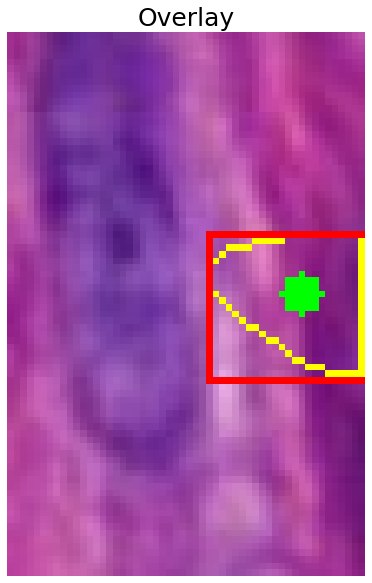

In [30]:
# plot the cropped overlay

pad = 30
crop1 = rand_bbox[0][0]-pad
if crop1 < 0: 
    crop1 = 0
crop2 = rand_bbox[1][0]+pad
if crop2 > overlay.shape[0]: 
    crop2 = overlay.shape[0]
crop3 = rand_bbox[0][1]-pad
if crop3 < 0: 
    crop3 = 0
crop4 = rand_bbox[1][1]+pad
if crop4 > overlay.shape[1]: 
    crop4 = overlay.shape[1]
crop_overlay = overlay[crop1:crop2,crop3:crop4,:]
plt.figure(figsize=(10,10))

plt.imshow(crop_overlay)
plt.axis('off')
plt.title('Overlay', fontsize=25)
plt.show()